In [9]:
import pandas as pd
import numpy as np
import os 
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [10]:
df = pd.read_csv("train_df_features.csv")

In [11]:
print(df.head())

              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000091_000000        Target  SEQ_000091                 0  SUBJ_032233   
1  SEQ_000091_000001        Target  SEQ_000091                 1  SUBJ_032233   
2  SEQ_000091_000002        Target  SEQ_000091                 2  SUBJ_032233   
3  SEQ_000091_000003        Target  SEQ_000091                 3  SUBJ_032233   
4  SEQ_000091_000004        Target  SEQ_000091                 4  SUBJ_032233   

       orientation                       behavior       phase  \
0  Seated Straight  Moves hand to target location  Transition   
1  Seated Straight  Moves hand to target location  Transition   
2  Seated Straight  Moves hand to target location  Transition   
3  Seated Straight  Moves hand to target location  Transition   
4  Seated Straight  Moves hand to target location  Transition   

                 gesture     acc_x  ...  tof_5_mean  tof_5_std  tof_5_min  \
0  Above ear - pull hair -4.492188  ...      

In [12]:
IMU_Cols = ['angular_jerk_x', 'angular_jerk_y', 'angular_jerk_z', 'angular_snap_x', 'angular_snap_y', 'angular_snap_z']
imu_data = df[IMU_Cols].values
label_col = "sequence_type"
print(imu_data[:])

[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.09074639   2.54877914   0.78577938   0.09074639   2.54877914
    0.78577938]
 [ -0.54619799  -3.47046612   1.02051504  -0.63694437  -6.01924526
    0.23473566]
 ...
 [ -2.22646723   4.18701246   4.26935981  -4.60007023   8.31354961
    8.58017933]
 [  1.03268763  -8.72816438  -4.01070428   3.25915486 -12.91517684
   -8.28006409]
 [  0.55862169   3.35471182   0.16870692  -0.47406594  12.0828762
    4.1794112 ]]


In [13]:
X = []
y = []

for seq_id, group in df.groupby("sequence_id"):
    X.append(group[IMU_Cols].values)
    y.append(group[label_col].iloc[0])  


In [14]:
max_len_sequences = int(np.percentile([len(seq) for seq in X], 95))

X_padded = pad_sequences(X, maxlen=max_len_sequences, dtype='float32', padding='post', truncating='post')

labelEncoder = LabelEncoder()

y_encoded = labelEncoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=2)

print(f"X_pad shape: {X_padded.shape}")
print(f"y_Categorical shape: {y_categorical.shape}")

X_pad shape: (7573, 115, 6)
y_Categorical shape: (7573, 2)


In [15]:
def LSTM_RNN_IMU_model(input_shape=(None, 6), num_classes=2):
    inputs = keras.layers.Input(shape = input_shape)

    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(inputs)
    x = keras.layers.Dropout(0.30)(x)
    x = keras.layers.LSTM(64)(x)
    x = keras.layers.Dropout(0.30)(x)

    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.30)(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.models.Model(inputs, outputs)

    return model
    

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_padded, y_categorical, test_size=0.20, shuffle = False
)

print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {Y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")

X train shape: (6058, 115, 6)
Y train shape: (6058, 2)
X test shape: (1515, 115, 6)
Y test shape: (1515, 2)


In [20]:
model = LSTM_RNN_IMU_model(input_shape=(max_len_sequences, len(IMU_Cols)))


In [21]:
optimizers = keras.optimizers.AdamW(learning_rate=1e-4, clipnorm=1.0)

model.compile(
    optimizer=optimizers,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history = model.fit(
    X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=50
)

model.summary()

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5707 - loss: 0.7326 - val_accuracy: 0.6482 - val_loss: 0.6605
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6529 - loss: 0.6675 - val_accuracy: 0.6515 - val_loss: 0.6405
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7068 - loss: 0.6028 - val_accuracy: 0.7439 - val_loss: 0.5557
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7800 - loss: 0.5126 - val_accuracy: 0.7518 - val_loss: 0.5366
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7964 - loss: 0.4943 - val_accuracy: 0.7558 - val_loss: 0.5243
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8091 - loss: 0.4618 - val_accuracy: 0.7611 - val_loss: 0.5244
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8291 - loss: 0.4324 - val_accuracy: 0.7809 - val_loss: 0.5045
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8336 - loss: 0.4087 - val_accu

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 115, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 115, 256)       │       138,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 115, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,008 (2.62 MB)

 Trainable params: 229,250 (895.51 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 458,502 (1.75 MB)

In [24]:
train_loss , train_accuracy = model.evaluate(X_train,Y_train)
test_loss , test_accuracy = model.evaluate(X_test,Y_test)

print(f"The train accuracy {train_accuracy}")
print(f"The test accuracy {test_accuracy}")

model.save("IMU_RNN_LSTM.h5")

190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9957 - loss: 0.0142
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9216 - loss: 0.3642


The train accuracy 0.9960383176803589
The test accuracy 0.9194719195365906


/tmp/ipykernel_62/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_62/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

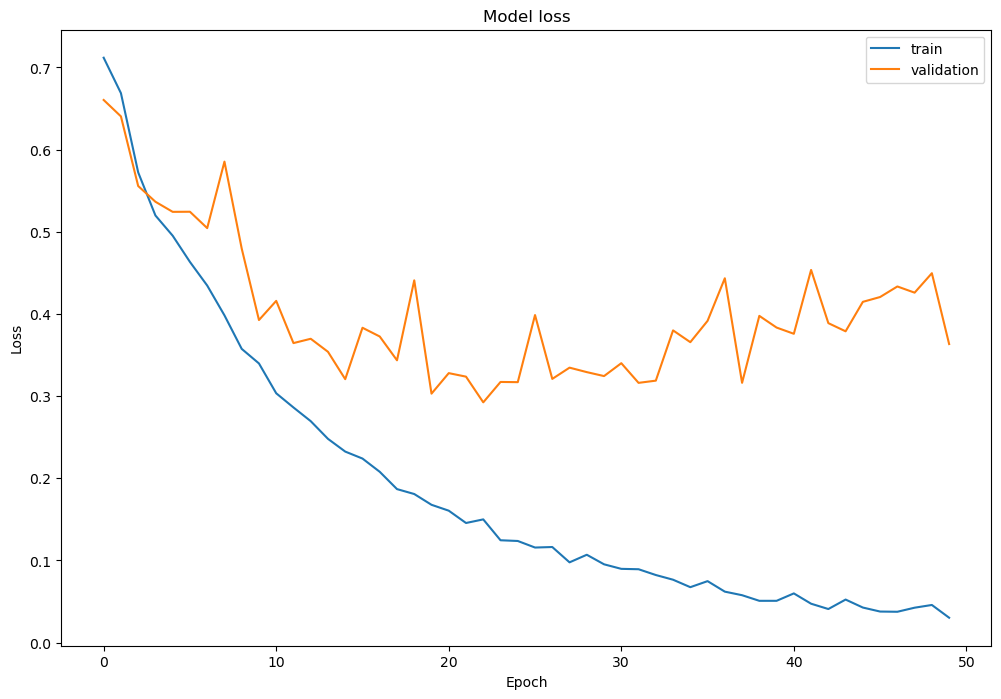

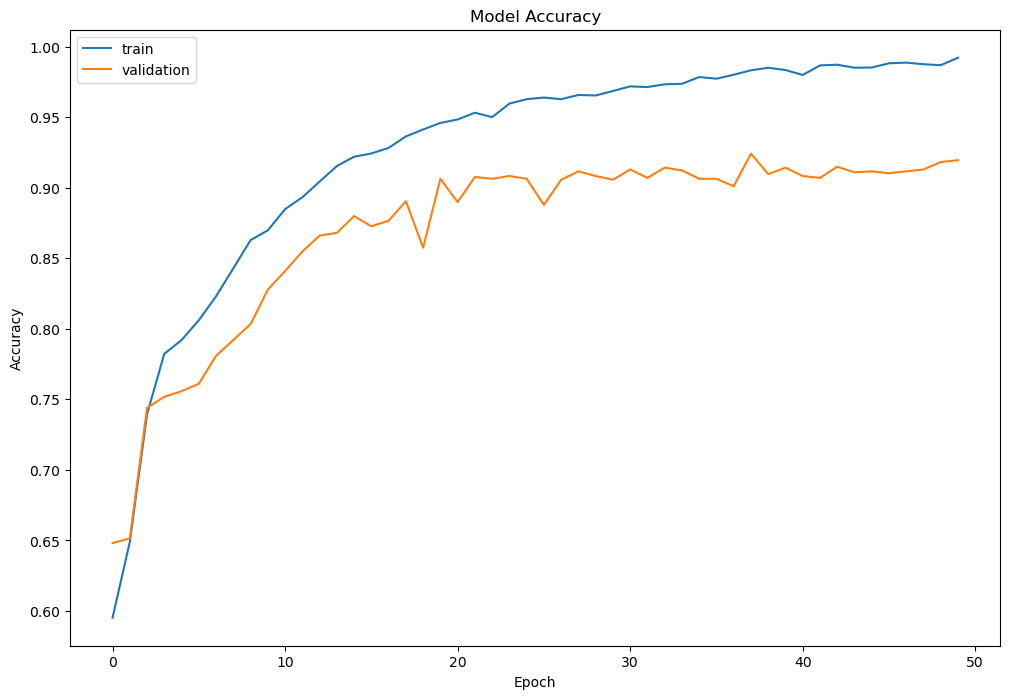

In [26]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')